캐글 데이터셋 : https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020

코드 참고 : https://www.kaggle.com/code/chaitanya99/recommendation-system-cf-anime/notebook

## 기본 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

## 데이터 불러오기

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload() # kaggle.json 파일 업로드

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ckstn0777","key":"83bd11b0207398edb0c504c8b09dc6f7"}'}

In [4]:
!mkdir -p ~/.kaggle # 캐글 폴더 생성
!cp kaggle.json ~/.kaggle # 캐글 폴더로 kaggle.json 복사
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list -s Anime-Recommendation # 검색했을때 리스트

ref                                                                    title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/hernan4444/anime-recommendation-database-2020                 Anime Recommendation Database 2020                661MB  2021-07-13 19:26:08           7329        325  1.0              
datasets/CooperUnion/anime-recommendations-database                    Anime Recommendations Database                     25MB  2016-12-21 04:58:34          34752       1016  0.8235294        
datasets/vishalmane109/anime-recommendations-database                  Anime  Database for Recommendation system           4MB  2020-06-20 16:10:32            604         24  0.85294116       
datasets/hernan4444/animeplanet-rec

In [6]:
# kaggle dataset 페이지 가보면 Copy API Command가 있더라
!kaggle datasets download -d hernan4444/anime-recommendation-database-2020

 99% 653M/661M [00:11<00:00, 99.2MB/s]
100% 661M/661M [00:11<00:00, 60.3MB/s]


In [7]:
!unzip anime-recommendation-database-2020.zip

Archive:  anime-recommendation-database-2020.zip
  inflating: anime.csv               
  inflating: anime_with_synopsis.csv  
  inflating: animelist.csv           
  inflating: html folder/html/1/details.html  
  inflating: html folder/html/1/pictures.html  
  inflating: html folder/html/1/recomendations.html  
  inflating: html folder/html/1/reviews_1.html  
  inflating: html folder/html/1/reviews_10.html  
  inflating: html folder/html/1/reviews_11.html  
  inflating: html folder/html/1/reviews_12.html  
  inflating: html folder/html/1/reviews_13.html  
  inflating: html folder/html/1/reviews_14.html  
  inflating: html folder/html/1/reviews_15.html  
  inflating: html folder/html/1/reviews_16.html  
  inflating: html folder/html/1/reviews_17.html  
  inflating: html folder/html/1/reviews_18.html  
  inflating: html folder/html/1/reviews_19.html  
  inflating: html folder/html/1/reviews_2.html  
  inflating: html folder/html/1/reviews_20.html  
  inflating: html folder/html/1/reviews

In [8]:
!ls

 anime.csv				  kaggle.json
 animelist.csv				  rating_complete.csv
 anime-recommendation-database-2020.zip   sample_data
 anime_with_synopsis.csv		  watching_status.csv
'html folder'


## 데이터 살펴보기
- This dataset contains information about 17.562 anime and the preference from 325.772 different users.

In [9]:
rating_df = pd.read_csv('./animelist.csv', low_memory=True, usecols=['user_id', 'anime_id', 'rating'])

In [10]:
# 무려 109,224,747 개... 그만큼 로드하는데 오래걸렸다. 
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109224747 entries, 0 to 109224746
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 2.4 GB


In [11]:
# 유저가 매긴 애니메이션 평점 -> 추천시스템에서 아주 중요한 정보
rating_df.head(10)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10
5,0,24,9
6,0,2104,0
7,0,4722,8
8,0,6098,6
9,0,3125,9


In [12]:
# user별로 애니메이션 평가 갯수, 보면 알겠지만 모든 애니메이션을 거의 다 평가한 사람도...
n_ratings = rating_df['user_id'].value_counts()
print(n_ratings)

20807     17546
140590    17534
281232    17533
147331    17526
131988    17520
          ...  
259248        1
259247        1
345120        1
287410        1
307120        1
Name: user_id, Length: 325770, dtype: int64


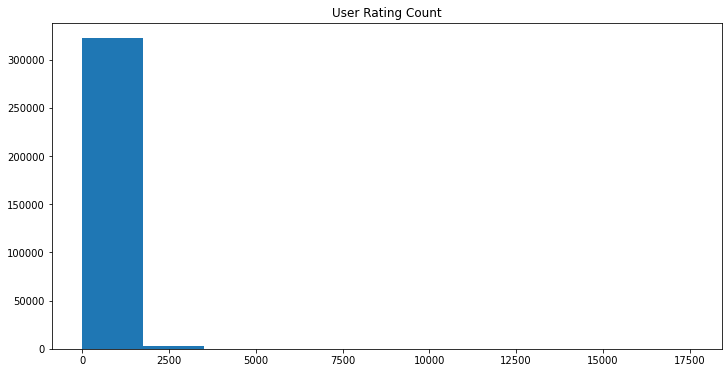

In [13]:
plt.figure(figsize=(12, 6))
plt.title('User Rating Count')

plt.hist(n_ratings)

plt.show() # 당연하겠지만 대부분은 0~1000 사이인듯하다

## Data Processing




### 평가를 많이 한 유저(400개 이상) 추출

In [14]:
type(n_ratings)

pandas.core.series.Series

In [15]:
# 평가를 많이한 유저 (400 이상) 추출
n_ratings[n_ratings >= 400].index

Int64Index([ 20807, 140590, 281232, 147331, 131988, 122341, 283786, 312302,
            297931,  85472,
            ...
             93967, 118278, 182920,  21761,   8812,   4529, 222826, 217331,
            141256,  67672],
           dtype='int64', length=91641)

In [16]:
# rating_df에서 400개 이상 평가한 유저만 필터링함
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()

In [17]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71418114 entries, 213 to 109224272
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 2.1 GB


### 평점을 0~1로 바꿔준다

In [18]:
# 평점을 0~10점에서 0~1로 바꿔주는 작업
min_rating = min(rating_df['rating']) # 0
max_rating = max(rating_df['rating']) # 10

In [19]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

In [20]:
AvgRating = np.mean(rating_df['rating'])
print('Avg', AvgRating)

Avg 0.40477935891013467


### 중복 여부를 확인해서 제거

In [21]:
# 중복 여부 확인해서 제거
duplicated = rating_df.duplicated()

In [22]:
duplicated[duplicated] # 한개 있네..;; 

19162033    True
dtype: bool

In [23]:
rating_df = rating_df[~duplicated] # 중복이 아닌 녀석들만 살려두고 중복인 녀석은 제거

### top 20유저 - top 20콘텐츠 행렬(400x400) 생성
- 그냥 재미로 생성해보는건가??

In [24]:
# 평점을 많이 남긴 유저 top 20을 뽑음
g = rating_df.groupby('user_id')['rating'].count()
top_users = g.dropna().sort_values(ascending=False)[:20]
print(top_users)

user_id
20807     17546
140590    17534
281232    17533
147331    17526
131988    17520
122341    17517
283786    17509
312302    17410
297931    17204
85472     16775
63900     16774
50485     16639
269633    16557
189037    15993
252520    15688
92529     15668
162615    15600
173716    15381
222150    15197
68042     14638
Name: rating, dtype: int64


In [25]:
# top_users의 user_id라는 인덱스와 병합하므로 join을 쓰는게 맞는듯.. 
top_r = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')
top_r

,user_id,anime_id,rating,rating_r
6334981,20807,8194,0.0,17546
6334982,20807,2225,0.0,17546
6334983,20807,13143,0.0,17546
6334984,20807,34572,1.0,17546
6334985,20807,34566,0.8,17546
...,...,...,...,...
96667639,312302,18967,0.0,17410
96667640,312302,13455,0.0,17410
96667641,312302,33390,0.0,17410
96667642,312302,42161,0.0,17410


In [26]:
# 마찬가지로 평점이 많이 남겨진 top 20 애니메이션 추출
g = rating_df.groupby('anime_id')['rating'].count()
top_animes = g.dropna().sort_values(ascending=False)[:20]
print(top_animes)

anime_id
16498    81545
11757    81142
6547     80345
4224     80247
1535     80162
9253     79271
5114     76420
19815    76160
5081     76131
1575     76097
10620    75298
30276    74364
20507    73949
6746     72937
15809    72069
9989     71677
2167     71253
22319    70836
2001     70772
226      70351
Name: rating, dtype: int64


In [27]:
# 상위 유저 20명이 상위 애니메이션 20개를 다 평가했다면 400 x 400이 나올거임
top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='anime_id')
top_r

,user_id,anime_id,rating,rating_r,rating_r
6335148,20807,6547,1.0,17546,80345
15537407,50485,6547,1.0,16639,80345
19786865,63900,6547,0.0,16774,80345
21008413,68042,6547,0.7,14638,80345
26368332,85472,6547,1.0,16775,80345
...,...,...,...,...,...
83297604,269633,4224,0.0,16557,80247
86986430,281232,4224,0.0,17533,80247
87794789,283786,4224,0.5,17509,80247
92237251,297931,4224,0.0,17204,80247


In [30]:
# 교차표 출력
pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)

anime_id,226,1535,1575,2001,2167,4224,5081,5114,6547,6746,9253,9989,10620,11757,15809,16498,19815,20507,22319,30276
user_id,,,,,,,,,,,,,,,,,,,,
20807,1.0,1.0,1.0,1.0,0.8,1.0,0.9,1.0,1.0,1.0,1.0,0.9,1.0,1.0,0.8,1.0,1.0,1.0,1.0,1.0
50485,0.0,0.6,1.0,1.0,0.9,1.0,1.0,1.0,1.0,0.9,1.0,0.9,0.6,1.0,1.0,0.9,1.0,1.0,1.0,0.8
63900,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.8,0.0,0.8,0.8,0.8
68042,0.8,1.0,0.9,1.0,0.7,0.9,1.0,0.9,0.7,0.8,0.9,0.8,0.4,0.4,0.6,0.9,0.3,0.2,0.5,0.9
85472,0.7,0.0,0.0,1.0,0.9,0.9,0.0,0.0,1.0,0.0,0.8,0.0,0.8,0.9,0.8,0.8,0.7,0.7,0.7,0.9
92529,0.9,0.9,1.0,1.0,0.0,0.8,0.0,0.9,0.9,0.0,1.0,0.0,0.8,0.9,0.8,0.9,0.9,0.8,0.8,1.0
122341,0.2,0.3,0.2,0.7,0.4,0.3,0.3,0.8,0.5,0.6,0.7,0.3,0.2,0.1,0.3,0.1,0.4,0.4,0.2,0.6
131988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140590,0.3,0.6,0.5,0.8,0.6,0.8,0.8,0.9,0.5,0.8,0.9,0.7,0.3,0.4,0.6,0.5,0.7,0.7,0.5,0.7


### Encoding categorical data
- sklearn.preprocessing.LabelEncoder 방식도 가능할거 같은데 여기서는 직접 하네

In [39]:
user_ids = rating_df['user_id'].unique().tolist()
print(len(user_ids))

user2user_encoded = {x: i for i, x in enumerate(user_ids)} # user_id에 대한 index 번호
user_encoded2user = {i: x for i, x in enumerate(user_ids)} # index 번호에 대한 user_id

rating_df["user"] = rating_df["user_id"].map(user2user_encoded) # map은 dict형도 가능함. 해당 user_id를 찾아서 index 번호를 지정

91641


In [40]:
anime_ids = rating_df['anime_id'].unique().tolist()
print(len(anime_ids))

anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)} # anime_id에 대한 index 번호
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)} # index 번호에 대한 anime_id

rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded) # map은 dict형도 가능함. 해당 anime_id를 찾아서 index 번호를 지정

17560


In [41]:
rating_df

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
109224268,353398,34086,0.0,91640,4428
109224269,353398,17909,0.0,91640,1453
109224270,353398,32924,0.0,91640,4837
109224271,353398,24627,0.0,91640,2095


### Data Spliting

## Collaborative Filtering(CF)

### Model Building
